Center fixed to: <SkyCoord (ICRS): (ra, dec) in deg
    ( 289.28472222, -33.52583333)>
(853, 859, 858, 864)
(853, 860, 855, 868)
Initial L: 441.7113271033704
converged in 219074 steps, 0.011411669116371637 acceptenace rate
Max Likelihood: 462.6998640824245


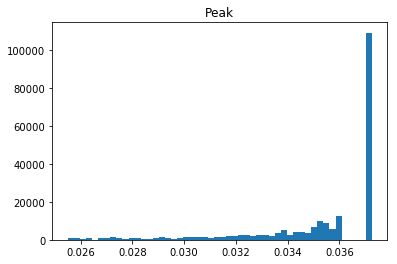

Peak = 0.03527138763102543 +- 0.0027743407564524442
Peak MAP = 0.03726190904045068


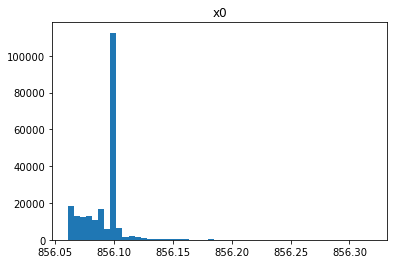

x0 = 856.0929386846491 +- 0.016822522206713413
x0 MAP = 856.1017454864359


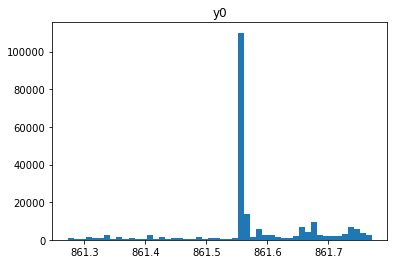

y0 = 861.5775146019367 +- 0.0936098627716384
y0 MAP = 861.552409660631


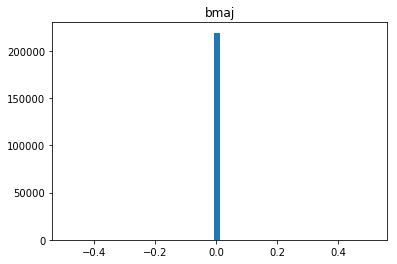

bmaj = 0.012003036075170002 +- 1.734723475976807e-18
bmaj MAP = 0.01200303607517


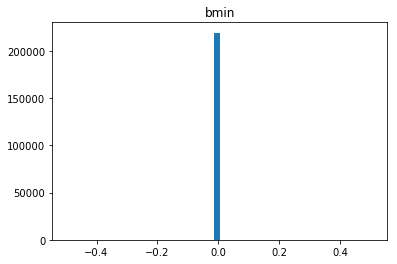

bmin = 0.005236406326294 +- 0.0
bmin MAP = 0.005236406326294


C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\astropy\visualization\wcsaxes\utils.py:88: RuntimeWarning: divide by zero encountered in log10
  log10_dv = np.log10(dv)
C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\astropy\visualization\wcsaxes\utils.py:91: RuntimeWarning: invalid value encountered in double_scalars
  frac = log10_dv - base
C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\astropy\visualization\wcsaxes\formatter_locator.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  imin = np.ceil(value_min / spacing)
C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\astropy\visualization\wcsaxes\formatter_locator.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  imax = np.floor(value_max / spacing)
C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\astropy\visualization\wcsaxes\formatter_locator.py:99: RuntimeWarning: invalid value encountered in double_scalars
  values = np.arange(imin, imax + 1, dtype=int)
C:\U

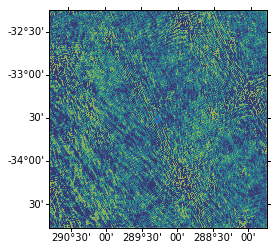

C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\astropy\visualization\wcsaxes\utils.py:88: RuntimeWarning: divide by zero encountered in log10
  log10_dv = np.log10(dv)
C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\astropy\visualization\wcsaxes\utils.py:91: RuntimeWarning: invalid value encountered in double_scalars
  frac = log10_dv - base
C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\astropy\visualization\wcsaxes\formatter_locator.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  imin = np.ceil(value_min / spacing)
C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\astropy\visualization\wcsaxes\formatter_locator.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  imax = np.floor(value_max / spacing)
C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\astropy\visualization\wcsaxes\formatter_locator.py:99: RuntimeWarning: invalid value encountered in double_scalars
  values = np.arange(imin, imax + 1, dtype=int)
C:\U

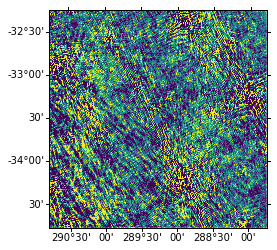

35.271387631 2.77434075645


In [2]:
from astropy.wcs import WCS
import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au
from astropy.io import fits
import pylab as plt
import numpy as np
from matplotlib.patches import Ellipse
from astropy.modeling.models import Ellipse2D

def ellipse(x,y,x0,y0,bmaj,bmin,bpa,peak):
    res = np.zeros_like(x,dtype=np.double)
    dx = x-x0
    dy = y-y0
    res += ((dy*np.cos(-bpa) + dx*np.sin(-bpa))/(bmaj/2.))**2 + ((-dy*np.sin(-bpa) + dx*np.cos(-bpa))/(bmin/2.))**2
    res *= np.log(0.5)
    np.exp(res,out=res)
    res *= peak
    return res
    
fitsfile = 'plckg004-19_150_multiscale.pybdsm_gaus_resid.fits'

hdu = fits.open(fitsfile)[0]
deg2pix = 1./np.sqrt(hdu.header['CDELT1']**2 + hdu.header['CDELT2']**2)
wcs = WCS(hdu.header)

#plt.imshow(hdu.data[0,0,:,:],origin='lower', cmap=plt.cm.viridis,vmin=-3*1.4e-3,vmax=5*1.4e-3)
#plt.show()

bmaj = hdu.header["BMAJ"]#deg
bmin = hdu.header["BMIN"]#deg
bpa = hdu.header["BPA"]#deg


x = np.arange(hdu.data.shape[3])
y = np.arange(hdu.data.shape[2])
Y,X = np.meshgrid(y,x,indexing='ij')
x0,y0 = 289.28456, -33.52576
#289.28472222222223 -33.52583333333333
c = ac.SkyCoord('289d17m05s','-33d31m33s',frame='icrs')
x0 = c.ra.deg
y0 = c.dec.deg
print("Center fixed to: {}".format(c))
crd = wcs.wcs_world2pix(((x0,y0,0,0),),0)
x0_,y0_ = crd[0,0:2]
tb = (int(x0_-bmaj*deg2pix/2.),int(x0_+bmaj*deg2pix/2.),int(y0_-bmaj*deg2pix/2.),int(y0_+bmaj*deg2pix/2.))
print(tb)
tb = (int(x0_-4),int(x0_+4),int(y0_-4),int(y0_+4))
tb = (853, 860 ,855, 868)
print(tb)
data = hdu.data[0,0,tb[2]:tb[3]+1,tb[0]:tb[1]+1]
X_t = X[tb[2]:tb[3]+1,tb[0]:tb[1]+1]
Y_t = Y[tb[2]:tb[3]+1,tb[0]:tb[1]+1]


beam0 = bmaj*bmin*np.pi/4./np.log(2)
rms = 1.4e-3
CdCt = rms**2 + (np.abs(data)*0.05)**2
std_CdCt = np.sqrt(CdCt)

def L(X,Y,peak,x0_=x0_,y0_=y0_,bmaj=bmaj,bmin=bmin,bpa=bpa):
    beam = bmaj*bmin*np.pi/4./np.log(2)
    e = ellipse(X,Y,x0_,y0_,bmaj*deg2pix,bmin*deg2pix,bpa*np.pi/180.,peak)
    L1 = np.sum(np.abs(e - data)/(std_CdCt*np.sqrt(beam/beam0)))
    #L2 = np.sum((e - data)**2/CdCt)
    
    return L1
    return np.exp(-L1)

#initial
paramName=['Peak','x0','y0','bmaj','bmin']
peaki = np.max(data)
peaki = 0.031
xi = x0_
yi = y0_
bmaji = bmaj
bmini = bmin

N = int(1e6)
params = np.zeros([N,5],dtype=np.double)
params[0,:] = peaki,xi,yi,bmaji,bmini

Li = L(X_t,Y_t,*params[0,:])
maxL = Li
maxParams = np.zeros(5,dtype=np.double)
maxParams = params[0,:]
print("Initial L: {}".format(Li))
i = 1
accepted = 0
bins = 50
while accepted < bins**2 and i < N:
    #peakj = np.exp(np.random.uniform(low=np.log(peaki/2.),high=np.log(peaki*2.)))
    peakj = 0.031 + rms*np.random.normal()
    xj = x0_#np.random.uniform(low = x0_ - 0.25,high = x0_ + 0.25)
    yj = y0_#np.random.uniform(low = y0_ - 0.25, high = y0_ + 0.25)
    bmajj = bmaj#np.random.uniform(low=bmaj,high=bmaj*1.1)
    bminj = bmin#np.random.uniform(low=bmin,high=bmin*1.1)
    Lj = L(X_t,Y_t,peakj,x0_=xj,y0_=yj,bmaj=bmajj,bmin=bminj)
    if Lj > Li or np.random.uniform() < np.exp(Lj-Li):
        peaki = peakj
        xi = xj
        yi = yj
        bmaji = bmajj
        bmini = bmini
        params[i,:] = peaki,xi,yi,bmaji,bmini
        Li = Lj
        #print("acceptance")
        accepted += 1
    else:
        params[i,:] = peaki,xi,yi,bmaji,bmini
    if Lj > maxL:
        maxL = Lj
        maxParams[:] =  peakj,xj,yj,bmajj,bminj
    i += 1
params = params[:i,:]
if accepted == bins**2:
    print("converged in {} steps, {} acceptenace rate".format(i,float(accepted)/i))
else :
    print("No convergence, {} acceptenace rate".format(i,float(accepted)/i))

print("Max Likelihood: {}".format(maxL))
for i in range(5):
    plt.hist(params[:,i],bins=bins)
    plt.title(paramName[i])
    plt.show()
    print("{} = {} +- {}".format(paramName[i],np.mean(params[:,i]),np.std(params[:,i])))
    print("{} MAP = {}".format(paramName[i],maxParams[i]))


params_mean = np.mean(params,axis=0)

e1 = ellipse(X,Y,params_mean[1],params_mean[2],
             params_mean[3]*deg2pix,params_mean[4]*deg2pix,bpa*np.pi/180.,params_mean[0])


ax = plt.subplot(projection=wcs,slices=('x','y',0,0))
ax.imshow(hdu.data[0,0,:,:],origin='lower', cmap=plt.cm.viridis,vmin=-3*1.4e-3,vmax=5*1.4e-3)
ax.imshow(e1,origin='lower', cmap=plt.cm.viridis,vmin=-3*1.4e-3,vmax=5*1.4e-3,alpha=0.5)

e2 = Ellipse(xy=crd[0,0:2], width=bmin*deg2pix, height=bmaj*deg2pix, angle = bpa, edgecolor='red',
                      facecolor='none')
ax.add_artist(e2)  
ax.scatter(x0_,y0_)

plt.show()

ax = plt.subplot(projection=wcs,slices=('x','y',0,0))
ax.imshow(hdu.data[0,0,:,:]-e1,origin='lower', cmap=plt.cm.viridis,vmin=-3*1.4e-3,vmax=5*1.4e-3)
#ax.imshow(e1,origin='lower', cmap=plt.cm.viridis,vmin=-3*1.4e-3,vmax=5*1.4e-3,alpha=0.5)

e2 = Ellipse(xy=crd[0,0:2], width=bmin*deg2pix, height=bmaj*deg2pix, angle = bpa, edgecolor='red',
                      facecolor='none')
ax.add_artist(e2)  
ax.scatter(x0_,y0_)

plt.show()
beam = bmaj*bmin*np.pi/4./np.log(2)

tb = (int(x0_-bmaj*deg2pix*3),int(x0_+bmaj*deg2pix*3),int(y0_-bmaj*deg2pix*3),int(y0_+bmaj*deg2pix*3))
X_t = X[tb[2]:tb[3]+1,tb[0]:tb[1]+1]
Y_t = Y[tb[2]:tb[3]+1,tb[0]:tb[1]+1]

flux = np.zeros(params.shape[0])
i = 0
while i < params.shape[0]:
    e1 = ellipse(X_t,Y_t,params[i,1],params[i,2],
             params[i,3]*deg2pix,params[i,4]*deg2pix,bpa*np.pi/180.,params[i,0])
    flux[i] = (np.sum(e1)/deg2pix**2/beam*1e3)
    i += 1
print(np.mean(flux),np.std(flux))


In [58]:
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                 1728                                                  
NAXIS2  =                 1728                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    1                                                  
EXTEND  =                    T                                                  
CRVAL1  =        289.271271453                                                  
CDELT1  =   -0.001458333333333                                                  
CRPIX1  =                865.0                                                  
CUNIT1  = 'deg     '                                                            
CTYPE1  = 'RA---SIN'        

In [62]:
hdu.header['BMAJ'] / hdu.header['CDELT1']

-8.230653308689883